In [77]:
import os,sys
import pathlib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.integrate import quad
import numpy as np
from astropy.cosmology import FlatLambdaCDM
from scipy import stats
import contextlib
import time
from scipy.optimize import curve_fit
sys.path.append(os.path.abspath('./practico3'))


In [2]:
import funciones_practico3 as fp3

In [3]:
path = './practico3/mgs.dat'
column_names = [
    'z','petro_r','ext_r','r50',
    'k0_u','k0_g','k0_r','k0_i','k0_z',
    'k01_u','k01_g','k01_r','k01_i','k01_z'
    ]
df = pd.read_csv(path,names=column_names, sep='\s+')
df = fp3.get_data(df)

<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_119142/1472254457.py:7: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(path,names=column_names, sep='\s+')
/home/jorgefederico/miniconda3/envs/vfproject/lib/python3.12/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jorgefederico/miniconda3/envs/vfproject/lib/python3.12/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Practico 3

In [4]:
list(df)

['z', 'm_r_k01', 'm_r_k0', 'r50_kpc', 'petro_r_corr', 'dl']

In [99]:
df.shape

(470349, 6)

<Axes: xlabel='z', ylabel='petro_r_corr'>

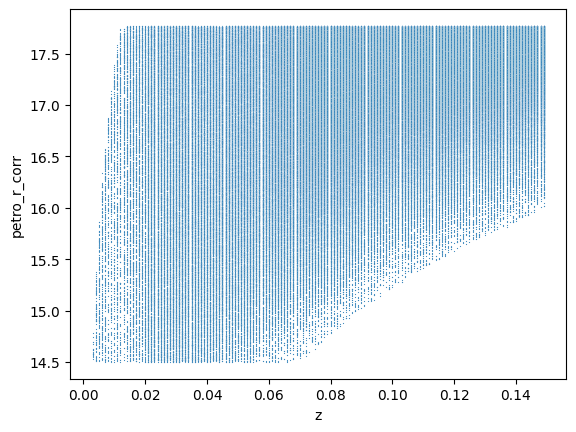

In [5]:
# z vs m_aparente corregida por ext
sns.scatterplot(data=df,x='z',y='petro_r_corr',s=0.7)

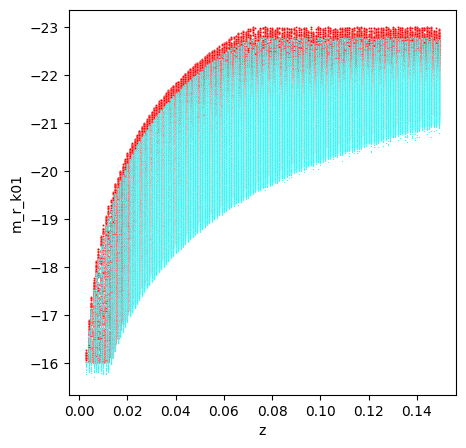

In [6]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
sns.scatterplot(data=df,x='z',y='m_r_k01',s=2.2,c='red',ax=ax)
sns.scatterplot(data=df,x='z',y='m_r_k0',s=0.7, c='cyan',ax=ax)
plt.gca().invert_yaxis()

## Calulo de $V_{max}$

<Axes: xlabel='dl', ylabel='z'>

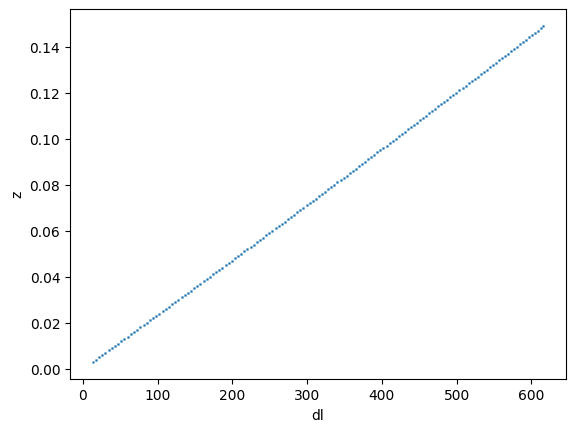

In [7]:
sns.scatterplot(data=df,x='dl',y='z',s=1.5)

In [8]:
# Interpolacion
slope, intercept, r_value, p_value, std_err = stats.linregress(df['dl'],df['z'])
# Dado una magnitud absoluta obtengo un dl
dl = np.array(10**(-0.2*(7.25+df["m_r_k01"])))

In [9]:
# Para cada m_r_k01 obtengo su zmax
z_max = slope*dl+intercept

In [21]:
# Funcion a integrar
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
def integrando(z,*,cosmo=FlatLambdaCDM(H0=70, Om0=0.3)):
    dl_2 = (cosmo.comoving_distance(z).value)**2
    f1 = (1+z)**2
    f2 = 0.3*(1+z)**3
    # Omega_k vale cero porque estamos trabajando en un universo sin curvatura (igual que en el practico 1)
    f3 = (dl_2)/(f1*((f2+0.7)**0.5))
    return (300000/70)*f3


In [22]:
# Tomamos el tiempo
@contextlib.contextmanager
def timer():
    start_time = time.time()
    yield time.time() - start_time
    print("--- %s seconds ---" % (time.time() - start_time))

In [15]:
len(z_max)

470349

In [23]:
# Integracion
with timer():
    a = [quad(integrando,0,z)[0] for z in z_max]

--- 383.49791264533997 seconds ---


In [51]:
vmax = np.array(a)
w = 1/vmax

## Calculo de la funcion Luminosidad

$\phi(M) = \sum_{i} \frac{N(M-\frac{dM}{2} \leq M_{i} \leq M+\frac{dM}{2})}{V_{max,i}}$

- Pasos:
    - Hacemos un histograma de magnitudes

In [58]:
magk01 = np.array(df['m_r_k01'])
counts,bins = np.histogram(magk01,bins=50)
# Get mids of histogram
mid_values = (bins[:-1] + bins[1:]) / 2
# List of lists of indexes of each element inside bin.
indxs = [np.where((t[0]<=magk01)&(magk01<=t[1]))[0] for t in tuple(zip(bins[:-1],bins[1:]))]

Tomando en cuenta que:

- $w = [\frac{1}{V_{max,1}},\frac{1}{V_{max,2}},...,\frac{1}{V_{max,N}}]$

Calculo: 
- $\phi(M) = \sum_{i} w_{i} N(M-\frac{dM}{2} \leq M_{i} \leq M+\frac{dM}{2})$

In [59]:
phi = [np.sum(w[indx]) for indx in indxs]
log_phi = np.log10(phi)

Text(0, 0.5, '$log_{10}(\\phi(M)dM)$')

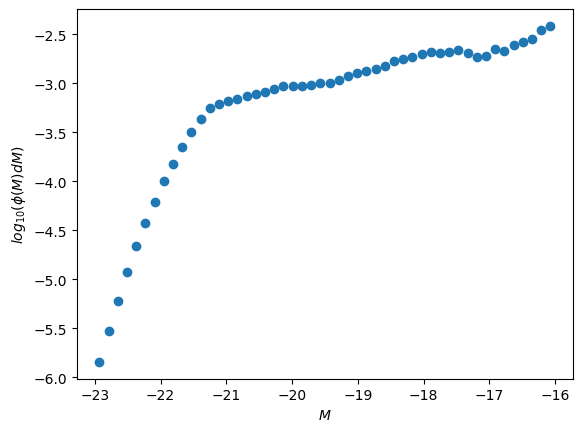

In [68]:
fit,ax = plt.subplots(1,1)
ax.scatter(mid_values,log_phi)
ax.set_xlabel(r"$M$")
ax.set_ylabel(r"$log_{10}(\phi(M)dM)$")



# Fitting
Para hacer el fitting utilizo Scipy con el modulo <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html#curve-fit">curve_fit</a>

Para hacer el fitting vamos a utilizar una forma algo simplificada de la funcion de Schechter:

- $A = \phi^{*} 0.4 ln(10)$ ; $B = M^{*}$ ; $C = 1 + \alpha$
- $log_{10}(\phi(M)) = log_{10}(A) - 0.4(M-B)C - \frac{10^{-0.4(M-B)}}{ln(10)}$


In [89]:
def log10phi(m,a,b,c):
    p1 = np.log10(a)
    p2 = -0.4*(m-b)*c
    p3 = -(10**(-0.4*(m-b)))/np.log(10)
    return p1+p2+p3

def coef_(a,b,c):
    phi = a/(0.4*np.log(10))
    m = b
    alpha = c - 1
    return phi,m,alpha

In [107]:
# p0 = initial guess
popt, pcov = curve_fit(log10phi, mid_values, log_phi,p0 = [0.0029,-21.3,-0.04])

In [108]:
coef_(*popt)

(0.0017072371513717538, -20.8558540377106, -1.1053251768430126)

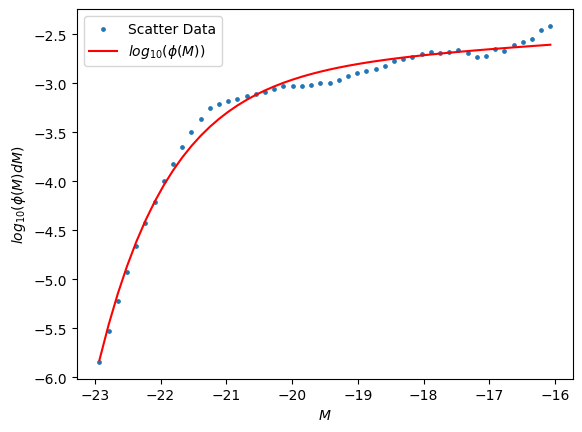

In [118]:
fit,ax = plt.subplots(1,1)
ax.scatter(mid_values,log_phi,s=5.8,label="Scatter Data")
ax.plot(mid_values,log10phi(mid_values,*popt),c="red",label=r"$log_{10}(\phi(M))$")
ax.set_xlabel(r"$M$")
ax.set_ylabel(r"$log_{10}(\phi(M)dM)$")
plt.legend()